In [6]:
# Modules for debugging
'''
import nibabel
from PIL import Image
import os
import fnmatch
import numpy as np
import ants
import concurrent.futures
import pandas as pd
import glob
import xml.etree.ElementTree as ET
import xmltodict
import shutil
import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D'''

import numpy as np

# Custom modules
from preprocessing_post_fastsurfer.alignment import *
from preprocessing_post_fastsurfer.cropping import *
from preprocessing_post_fastsurfer.extraction import *
from preprocessing_post_fastsurfer.file_handling import *
from preprocessing_post_fastsurfer.mesh_creation import *
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *

np.set_printoptions(precision=2, suppress=True)

## Reference brain
Extract the brain from the MRI reference MRI for use in affine alginment

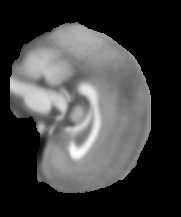

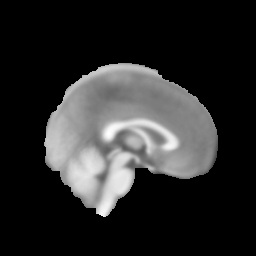

In [7]:
# NB seems that fastsrufer brain is better
reference_brain_array_mni = extract_brain("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin.nii", "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin_mask.nii")

display_array(reference_brain_array_mni)

reference_brain_array_fastsurfer = extract_brain("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/fastsurfer-processed/mri/orig_nu.mgz", "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/fastsurfer-processed/mri/mask.mgz")

display_array(reference_brain_array_fastsurfer)


## Main code

In [8]:
# Initialise a list of subject objects from the given directory
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch disk/full-datasets/adni1-complete-3T-processed"

subject_list = find_subjects(data_path)


In [ ]:
# Perform affine alignment on all subjects in the list, using the reference brain
alignment_parallel(subject_list, reference_brain_array_fastsurfer)

In [ ]:
# Crop all aligned brains to remove empty space
crop_subjects_parallel(subject_list, 'brain_aligned.nii', is_full_brain=True, display_3d=False)

In [ ]:
# Align the parcellation file using the same affine transformation used on the brain
# NB affine alinged aparcs may be inaccurate
aux_alignment_parallel(subject_list, 'aparc', is_aparc=True)

In [ ]:
# Extract left and right hippocampus from non-aligned brains (in the same file)
extract_region_parallel(subject_list, [17, 53], 'orig_nu', 'aparc', is_aligned=False)

In [ ]:
# Crop hippocampi
crop_subjects_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus.nii', is_full_brain=False, display_3d=True)

In [ ]:
# Extract left and right hippocampus from aligned brains (in the same file)
extract_region_parallel(subject_list, [17, 53], 'brain_aligned', 'aparc_aligned', is_aligned=True)

In [ ]:
# Crop hippocampi
crop_subjects_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_aligned.nii', is_full_brain=False, display_3d=True)


In [ ]:
# Convert cropped hippocampi point clouds using walking cubes method
volume_to_mesh_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_cropped.nii', downsample_factor=50)

In [ ]:
# Convert aligned cropped hippocampi point clouds using walking cubes method
volume_to_mesh_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_aligned_cropped.nii', downsample_factor=50)

In [13]:
# Delete all non-cropped hippocampi
for subject in subject_list:
    
    delete_file_matching(subject.path, 'Left-Hippocampus_Right-Hippocampus.nii')
    
    delete_file_matching(subject.path, 'Left-Hippocampus_Right-Hippocampus_aligned.nii')

In [ ]:
# Downsample all hippocampi meshes to have the same vector size for use in pytorch
random_sample_mesh_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_cropped_mesh.npy')

In [ ]:
random_sample_mesh_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_aligned_cropped_mesh.npy')

CN


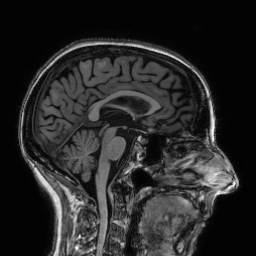

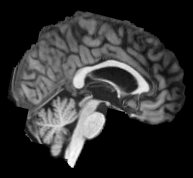

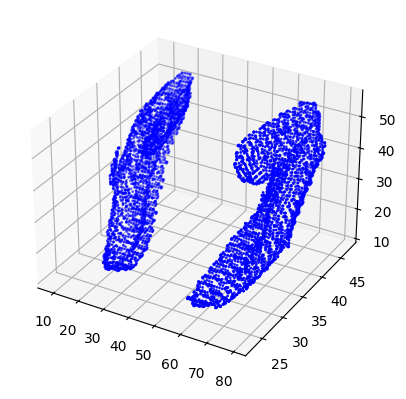

In [11]:
for subject in subject_list:
    
    research_group = subject.xml_df['idaxs']['project']['subject']['researchGroup']
    
    print(research_group)
    
    display_image(nibabel.load(subject.orig_nu))
    
    display_image(nibabel.load(subject.brain_aligned_cropped))
    
    display_mesh(np.load(os.path.join(subject.path, 'Left-Hippocampus_Right-Hippocampus_cropped_mesh.npy')), downsample_factor=1)
    
    break

In [ ]:
# 1yr 3t size before 135gb
# 1yr 3t size after  55gb

# Note write about storage size in report

In [ ]:
'''# Data type testing
for subject in subject_list:
    
    image = nibabel.load(os.path.join(subject.path, subject.mask))
    
    print(image.header)
    
    print(image.dataobj.dtype)
    
    print(np.max(image.dataobj))
    
    print(image.get_fdata().dtype)
    
    print(np.max(image.get_fdata()))
    
    new_image = nibabel.Nifti1Image(np.asarray(image.dataobj).astype('uint32'), np.eye(4))
    
    print(new_image.dataobj.dtype)
    
    print(np.max(new_image.dataobj))
    
    break'''

In [ ]:
for subject in subject_list:
    
    subject_dict = subject.xml_df
    
    research_group = subject_dict['idaxs']['project']['subject']['researchGroup']
    
    visit_identifier = subject_dict['idaxs']['project']['subject']['visit']['visitIdentifier']
    
    sex = subject_dict['idaxs']['project']['subject']['subjectSex']
    
    age = subject_dict['idaxs']['project']['subject']['study']['subjectAge']
    
    weight = subject_dict['idaxs']['project']['subject']['study']['weightKg']
    
    apoe_a1 = subject_dict['idaxs']['project']['subject']['subjectInfo'][0]['#text']
    
    apoe_a2 = subject_dict['idaxs']['project']['subject']['subjectInfo'][1]['#text']
    
    print(research_group)
    
    print(visit_identifier)
    
    print(sex)
    
    print(age)
    
    print(weight)
    
    print(apoe_a1)
    
    print(apoe_a2)

    # Assessment scores, not all are present for a given subject
    mmscore = None
    gdtotal = None
    cdglobal = None
    faqtotalscore = None
    npiscore = None
    
    assessments = subject_dict['idaxs']['project']['subject']['visit']['assessment']
    
    print(assessments)
    
    for assessment in assessments:
        # Loop through each component in the assessment
        for component in assessment['component']:
            # Extract the assessmentScore element and its attribute
            
            print(component[0]['#text'])
            
            #assessment_score = component['assessmentScore']
            
            
            '''attribute = assessment_score.get('@attribute')  # Get the attribute name
            score = assessment_score.text.strip() if assessment_score.text else None

            # Check for the corresponding score based on the attribute
            if attribute == "MMSCORE":
                mmscore = score
            elif attribute == "GDTOTAL":
                gdtotal = score
            elif attribute == "CDGLOBAL":
                cdglobal = score
            elif attribute == "FAQTOTAL":
                faqtotalscore = score
            elif attribute == "NPISCORE":
                npiscore = score'''

    # Print the extracted scores
    print(f"MMSCORE: {mmscore}")
    print(f"GDTOTAL: {gdtotal}")
    print(f"CDGLOBAL: {cdglobal}")
    print(f"FAQTOTAL: {faqtotalscore}")
    print(f"NPISCORE: {npiscore}")
    
    
        